In [3]:
import neptune.new as neptune

run = neptune.init(
    project="oliveira/captionImageMonitoring",
    api_token="eyJhcGlfYWRkcmVzcyI6Imh0dHBzOi8vYXBwLm5lcHR1bmUuYWkiLCJhcGlfdXJsIjoiaHR0cHM6Ly9hcHAubmVwdHVuZS5haSIsImFwaV9rZXkiOiI2MmEyOGVhMC0xMjA1LTRhMTMtOTFkNi0wNmE5MzNhZWM4ZmUifQ==",
)  # your credentials

https://app.neptune.ai/oliveira/captionImageMonitoring/e/CAPTION-1
Remember to stop your run once you’ve finished logging your metadata (https://docs.neptune.ai/api-reference/run#.stop). It will be stopped automatically only when the notebook kernel/interactive console is terminated.


### DataLoader

In [4]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
import numpy as np

from torch import nn
from torch import Tensor
from PIL import Image
from torchvision    import transforms
from torchvision.transforms import Compose, Resize, ToTensor
from einops import rearrange, reduce, repeat
from einops.layers.torch import Rearrange, Reduce
from torchsummary import summary

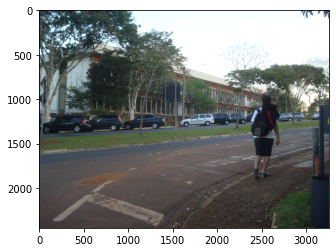

In [5]:
img = Image.open('../img_test.jpg')

fig = plt.figure()
plt.imshow(img)

In [6]:
# resize image
transform = Compose([Resize((224, 224)), ToTensor()])
x = transform(img)
x = x.unsqueeze(0) # add batch dim
x.shape

torch.Size([1, 3, 224, 224])

### Organize shape on array Example:

In [7]:
print(rearrange(np.arange(50), '(h n) -> h n', h=5).shape)# sinaliza de alguma forma que vai divir antes (h n)
print(rearrange(np.arange(50), '(h n) -> h n', h=10).shape)
print(rearrange(np.arange(50), '(h n) -> n h', h=10).shape)

(5, 10)
(10, 5)
(5, 10)


In [8]:
"""
# a grayscale image (of shape height x width)
>>> image = np.random.randn(30, 40)

# change it to RGB format by repeating in each channel
>>> repeat(image, 'h w -> h w c', c=3).shape
(30, 40, 3)
"""

"\n# a grayscale image (of shape height x width)\n>>> image = np.random.randn(30, 40)\n\n# change it to RGB format by repeating in each channel\n>>> repeat(image, 'h w -> h w c', c=3).shape\n(30, 40, 3)\n"

In [9]:
# Operation patches | i can see patches
# when put (h w) or (s1 s2 c) significa flatten operation
patch_size = 16 # 16 pixels

# b = 1, c = 1, (h s1) = 224, (w s2) = 224

#(h w) = 14*14, # (s1 s2 c) = 1*16*16

"""A leitura que eu tenho disso é que de alguma forma s1 ou s2 será retirado de h e w respectivamente.
E assumirar outra posicao ou seja (h s1) = 224, implica dizer que s1 já estar contido dentro de h na forma
de m.m.c.

Por exemplo: quando eu coloco patch_size = 15 ele mostra esse error:

EinopsError: Shape mismatch, can't divide axis of length 224 in chunks of 15.

(h*w) Quantidade de blocos.
(s1*s2*c) tamanho do patch
"""
pathes = rearrange(x, 'b c (h s1) (w s2) -> b (h w) (s1 s2 c)', s1=patch_size, s2=patch_size)

fig = plt.figure()
#plt.imshow((pathes[0,44,:].reshape(patch_size, patch_size)))

#plt.figure(figsize=(4, 4))


# plt.imshow(image.astype('uint8'))
# plt.axis('off')

# resized_image = tf.image.resize(
#     tf.convert_to_tensor([image]), size = (image_size, image_size)
# )

# patches = Patches(patch_size)(resized_image)
# print(f'Image size: {image_size} X {image_size}')
# print(f'Patch size: {patch_size} X {patch_size}')
# print(f'Patches per image: {patches.shape[1]}')
# print(f'Elements per patch: {patches.shape[-1]}')

# n = int(np.sqrt(patches.shape[1]))
# plt.figure(figsize=(4, 4))

<Figure size 432x288 with 0 Axes>

In [10]:
import yaml

with open('config_vit.yaml', 'r') as file:
    parameters = yaml.safe_load(file)

In [11]:
parameters.keys()

dict_keys(['patch_size', 'emb_size', 'img_size', 'num_heads', 'dropout', 'expansion_embbeding', 'depth', 'n_classes', 'in_channels', 'emb_size_multi_head_attention'])

In [37]:
parameters['in_channels'] = 3

### Patch embedding

In [39]:
#crop on patches
"""
É importante fazer as contas certinhas para que os patches sejam cortados corretamente.
"""
class PatchEmbedding(nn.Module):
    
    def __init__(self, in_channels: int = parameters['in_channels'],
                 patch_size: int = parameters['patch_size'],
                 emb_size: int = parameters['emb_size'],
                 img_size: int = parameters['img_size']):
        
        self.patch_size = patch_size
        super().__init__()
        self.projection = nn.Sequential(
            nn.Conv2d(in_channels, emb_size, kernel_size=patch_size, stride=patch_size),#geração dos patches
            Rearrange('b c (h) (w) -> b (h w) c'),
        )
        
        
        self.cls_token = nn.Parameter(torch.randn(1,1, emb_size))
        
        
        #flat patches
        self.positions = nn.Parameter(torch.randn((img_size // patch_size) **2 + 1, emb_size))
        
        
    def forward(self, x: Tensor):
        """
        debug: Parece que o modelo ta associando o mesmo cls_token para cada patch da imagem.
        """
        b, _, _, _ = x.shape
        
        x = self.projection(x)
        
        cls_tokens = repeat(self.cls_token, '() n c -> b n c', b=b)
        # prepend the cls token to the input
        
        x = torch.cat([cls_tokens, x], dim=1)
        # add position embedding
        x += self.positions
        return x
    
PatchEmbedding()(x).shape

torch.Size([1, 197, 768])

### MultiHeadAttention

In [40]:
class MultiHeadAttention(nn.Module):
    def __init__(self, emb_size: int = parameters['emb_size_multi_head_attention'],
                 num_heads: int = parameters['num_heads'],
                 dropout: float = parameters['dropout']):
        
        super().__init__()
        
        self.emb_size = emb_size
        self.num_heads = num_heads
        self.keys = nn.Linear(emb_size, emb_size)
        self.queries = nn.Linear(emb_size, emb_size)
        self.values = nn.Linear(emb_size, emb_size)
        
        self.att_drop = nn.Dropout(dropout)
        self.projection = nn.Linear(emb_size, emb_size)
        
        
    def forward(self, x : Tensor, mask: Tensor = None) -> Tensor:
        # split keys, queries and values in num_heads
        """
        (h d) Representation division between dimension/num_heads
        task:colocar um raise na divisao num_heads por  embbeding gerado.
        h -> representa a quantidade heads geradas
        """
        queries = rearrange(self.queries(x), "b n (h d) -> b h n d", h=self.num_heads)
        
        keys = rearrange(self.keys(x), "b n (h d) -> b h n d", h=self.num_heads)
        
        values  = rearrange(self.values(x), "b n (h d) -> b h n d", h=self.num_heads)
        # sum up over the last axis
        # matrix multiplication between queries and keys, a.k.a sum up over the last axis.
        energy = torch.einsum('bhqd, bhkd -> bhqk', queries, keys) # batch, num_heads, query_len, key_len
        
        if mask is not None:
            fill_value = torch.finfo(torch.float32).min
            energy.mask_fill(~mask, fill_value)
            
        scaling = self.emb_size ** (1/2)
        
        att = F.softmax(energy, dim=-1) / scaling
        
        att = self.att_drop(att)
        # sum up over the third axis
        out = torch.einsum('bhal, bhlv -> bhav ', att, values)
        
        out = rearrange(out, "b h n d -> b n (h d)")
        out = self.projection(out)
        return out

### Residual Add

In [41]:
class ResidualAdd(nn.Module):
    def __init__(self, fn):
        super().__init__()
        self.fn = fn
        
    def forward(self, x, **kwargs):
        res = x
        x = self.fn(x, **kwargs)
        x += res
        return x

### Feed Foward

In [42]:
class FeedForwardBlock(nn.Sequential):
    def __init__(self, emb_size: int, expansion: int = 2, drop_p: float = 0.):
        super().__init__(
            nn.Linear(emb_size, expansion * emb_size),
            nn.ReLU(),
            nn.Dropout(drop_p),
            nn.Linear(expansion * emb_size, emb_size),
        )

### Tranformer encoder Block

In [43]:
class TransformerEncoderBlock(nn.Sequential):
    def __init__(self,
                 emb_size: int = parameters['emb_size'],
                 drop_p: float = parameters['dropout'],
                 forward_expansion: int = parameters['expansion_embbeding'],
                 forward_drop_p: float = parameters['dropout'],
                 ** kwargs):
        super().__init__(
            ResidualAdd(nn.Sequential(
                nn.LayerNorm(emb_size),
                MultiHeadAttention(emb_size, **kwargs),
                nn.Dropout(drop_p)
            )),
            ResidualAdd(nn.Sequential(
                nn.LayerNorm(emb_size),
                FeedForwardBlock(
                    emb_size, expansion=forward_expansion,
                    drop_p=forward_drop_p),
                nn.Dropout(drop_p)
            )
            ))

### Transformer Encoder

In [44]:
class TransformerEncoder(nn.Sequential):
    def __init__(self,
                 depth: int = parameters['depth'],
                 **kwargs):
        super().__init__(*[TransformerEncoderBlock(**kwargs) for _ in range(depth)])

In [45]:
patches_embedded = PatchEmbedding()(x)
TransformerEncoderBlock()(patches_embedded).shape

torch.Size([1, 197, 768])

In [46]:
class ClassificationHead(nn.Sequential):
    def __init__(self, emb_size: int = parameters['emb_size'], n_classes: int = parameters['n_classes']):
        
        super().__init__(
            Reduce('b n e -> b e', reduction='mean'),
            nn.LayerNorm(emb_size), 
            nn.Linear(emb_size, n_classes))

In [47]:
class ViT(nn.Sequential):
    def __init__(self,     
                in_channels: int = parameters['in_channels'],
                patch_size: int = parameters['patch_size'],
                emb_size: int = parameters['emb_size'],
                img_size: int = parameters['img_size'],
                depth: int = parameters['depth'],
                n_classes: int = parameters['depth'],
                **kwargs):
        super().__init__(
            PatchEmbedding(in_channels, patch_size, emb_size, img_size),
            TransformerEncoder(depth, emb_size=emb_size, **kwargs),
            ClassificationHead(emb_size, n_classes)
        )

In [54]:
nn.Sequential.forward

<function torch.nn.modules.container.Sequential.forward(self, input)>

In [ ]:
"""
>>> class A:
        def __init__(self, a="a",*argv,**karg):
            super().__init__(*argv,**karg)
            self.a=a

    
>>> class B(A):
        def __init__(self, b="b",*argv,**kargv):
            super().__init__(*argv,**kargv)
            self.b=b

        
>>> class Bad(B):
        def __init__(self,b="bad",*arg,**kargv):
            self.b=b

        
>>> b=B()
>>> b.a
'a'
>>> b.b
'b'
>>> bad=Bad()
>>> bad.b
'bad'
>>> bad.a
Traceback (most recent call last):
  File "<pyshell#220>", line 1, in <module>
    bad.a
AttributeError: 'Bad' object has no attribute 'a'
>>> 
"""

In [56]:
"""
When to implemented super, the class inherits other class.
"""
class A:
    def __init__(self, a="a",*argv,**karg):
        super().__init__(*argv,**karg)
        self.a=a
        
class B(A):
    def __init__(self, b="b",*argv,**kargv):
        super().__init__(*argv,**kargv)
        self.b=b
        
class Bad(B):
    def __init__(self,b="bad",*arg,**kargv):
        super().__init__(*arg,**kargv) # comment this line
        self.b=b

b=B()
print(b.a)
print(b.b)
bad=Bad()
print(bad.b)
print(bad.a)

a
b
bad
a


In [19]:
#summary(ViT(), (1, 224, 224), device='cuda')
model = ViT()

In [20]:
#x.shape
model.forward(x)

tensor([[ 0.0349, -0.4286,  0.8303,  0.0882,  0.4381, -0.8411,  0.2188,  0.6519,
          0.3147, -0.2887,  0.4665, -0.3879]], grad_fn=<AddmmBackward>)

### Training VIT

In [21]:
from __future__ import print_function
import argparse
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.autograd import Variable

In [22]:
args={}
kwargs={}
args['batch_size']=15
args['test_batch_size']=15
args['epochs']=10  #The number of Epochs is the number of times you go through the full dataset. 
args['lr']=0.01 #Learning rate is how fast it will decend. 
args['momentum']=0.5 #SGD momentum (default: 0.5) Momentum is a moving average of our gradients (helps to keep direction).

args['seed']=1 #random seed
args['log_interval']=10
args['cuda']=True


In [23]:
#load the data
train_loader = torch.utils.data.DataLoader(
    datasets.MNIST('../data', train=True, download=True,
                   transform=transforms.Compose([Resize((224, 224)),
                       transforms.ToTensor()#,
                       #transforms.Normalize((0.1307,), (0.3081,))
                   ])),
    batch_size=args['batch_size'], shuffle=True, **kwargs)
test_loader = torch.utils.data.DataLoader(
    datasets.MNIST('../data', train=False, transform=transforms.Compose([Resize((224, 224)),
                       transforms.ToTensor()#,
                       #transforms.Normalize((0.1307,), (0.3081,))
                   ])),
    batch_size=args['test_batch_size'], shuffle=True, **kwargs)

criterion = torch.nn.CrossEntropyLoss()


  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting ../data/MNIST/raw/train-images-idx3-ubyte.gz to ../data/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting ../data/MNIST/raw/train-labels-idx1-ubyte.gz to ../data/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting ../data/MNIST/raw/t10k-images-idx3-ubyte.gz to ../data/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting ../data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ../data/MNIST/raw

Processing...
Done!


/home/paim/anaconda3/envs/ocr_estacio/lib/python3.9/site-packages/torchvision/datasets/mnist.py:502: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:143.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


In [24]:

def train(epoch):
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        if args['cuda']:
            data, target = data.cuda(), target.cuda()
        #Variables in Pytorch are differenciable. 
        data, target = Variable(data), Variable(target)
        #This will zero out the gradients for this batch. 
        optimizer.zero_grad()
        output = model(data)
        # Calculate the loss The negative log likelihood loss. It is useful to train a classification problem with C classes.
        output = F.log_softmax(output, dim=1)
        
        loss = criterion(output,  target)
        #dloss/dx for every Variable 
        loss.backward()
        #to do a one-step update on our parameter.
        optimizer.step()
        #Print out the loss periodically. 
        if batch_idx % args['log_interval'] == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))

def test():
    model.eval()
    test_loss = 0
    correct = 0
    for data, target in test_loader:
        if args['cuda']:
            data, target = data.cuda(), target.cuda()
        data, target = Variable(data, volatile=True), Variable(target)
        output = model(data)
        test_loss += F.nll_loss(output, target, size_average=False).data[0] # sum up batch loss
        pred = output.data.max(1, keepdim=True)[1] # get the index of the max log-probability
        correct += pred.eq(target.data.view_as(pred)).long().cpu().sum()

    test_loss /= len(test_loader.dataset)
    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))




In [25]:
#model = Net()
if args['cuda']:
    model.cuda()

optimizer = optim.SGD(model.parameters(), lr=args['lr'], momentum=args['momentum'])

for epoch in range(1, args['epochs'] + 1):
    train(epoch)
    test()


Train Epoch: 1 [0/60000 (0%)]	Loss: 2.671906


RuntimeError: CUDA out of memory. Tried to allocate 18.00 MiB (GPU 0; 3.82 GiB total capacity; 2.43 GiB already allocated; 20.81 MiB free; 2.53 GiB reserved in total by PyTorch)

In [23]:
del model